## 1） Read Data

In [1]:
# ! git clone https://huggingface.co/datasets/YuAnthony/tnews

In [2]:
# !pip install matplotlib

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
import torch
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import RobertaModel
from transformers import AdamW
# from transformers import BertPreTrainedModel, BertConfig, BertModel

In [5]:
from sklearn.metrics import accuracy_score,classification_report
from sklearn.utils import shuffle

In [6]:
class config():
    train_data_path = './tnews/train.json'
    dev_data_path = './tnews/dev.json'
    test_data_path = './tnews/test.json'
    label_data_path = './tnews/labels.json'
    bert_name = "hfl/chinese-roberta-wwm-ext"
    max_length  = 50
    batch_size = 8
    epochs = 2
    device = "cuda" if torch.cuda.is_available() else "cpu"
    learning_rate = 2e-5

In [7]:
def get_raw_data(config,data_type='train',nums_sample = -1):
    text = []
    label = []
    data_path = {"train":config.train_data_path,
                "dev":config.dev_data_path,
                "test":config.test_data_path}[data_type]
    with open(data_path, encoding='utf-8')as file:
        for line in file.readlines():
            line = line.strip()
            dic = json.loads(line)
            text.append(dic['sentence'])
            label.append(dic['label'])
    
    df = pd.DataFrame()
    df['text'] = text
    df['label'] = label
    df  = shuffle(df).head(nums_sample)
    return df

In [8]:
def get_labels_dict(config):
    label_dict = {}
    with open(config.label_data_path, encoding='utf-8')as file:
        for line in file.readlines():
            line = line.strip()
            dic = json.loads(line)
            label_dict[dic['label']]=dic['label_desc']
    return label_dict

In [9]:
df_train = get_raw_data(config,"train",100)
df_dev = get_raw_data(config,"dev",100)
labels_dict = get_labels_dict(config)

In [10]:
df_train.head()

,text,label
30569,资本家的资本是怎样来的？,104
14546,山西的大院，哪个最值得去？,112
52649,号外｜最新太阳能发电、储能百亿富豪榜：22家公司30人上榜,109
10791,汽车大灯发黄模糊不够亮？别傻傻被4S店忽悠，教你3招轻松搞定！,107
50220,「封口避谈强吻事件」麦明诗透视tube dress力压师姐,102


In [11]:
labels_dict

{'100': 'news_story',
 '101': 'news_culture',
 '102': 'news_entertainment',
 '103': 'news_sports',
 '104': 'news_finance',
 '106': 'news_house',
 '107': 'news_car',
 '108': 'news_edu',
 '109': 'news_tech',
 '110': 'news_military',
 '112': 'news_travel',
 '113': 'news_world',
 '114': 'news_stock',
 '115': 'news_agriculture',
 '116': 'news_game'}

## 2) Process Data According to Prompt Template

In [12]:
tokenizer = AutoTokenizer.from_pretrained(config.bert_name)

In [13]:
label_dic = {'100': '民生', '101': '文化', '102': '娱乐', '103': '体育', '104': '财经', '106': '房产', '107': '汽车',
                          '108': '教育', '109': '科技', '110': '军事', '112': '旅游', '113': '国际', '114': '证券', '115': '农业',
                          '116': '游戏'}

In [14]:
label_index = {k: i for i, (k, v) in enumerate(label_dic.items())}

In [15]:
# label_index

In [16]:
label_idx_dic = {k: tokenizer.convert_tokens_to_ids(list(v)) for k, v in label_dic.items()}

In [17]:
# label_idx_dic #these tokens to fill prompt tempalte

In [18]:
def get_token_length(text):
    encoding = tokenizer(text)
    return len(encoding['input_ids'])

In [19]:
df_train.head()

,text,label
30569,资本家的资本是怎样来的？,104
14546,山西的大院，哪个最值得去？,112
52649,号外｜最新太阳能发电、储能百亿富豪榜：22家公司30人上榜,109
10791,汽车大灯发黄模糊不够亮？别傻傻被4S店忽悠，教你3招轻松搞定！,107
50220,「封口避谈强吻事件」麦明诗透视tube dress力压师姐,102


In [20]:
token_len_list = df_train['text'].apply(lambda x:get_token_length(x))

(array([ 4.,  5., 13., 14., 17., 10., 13., 17.,  3.,  4.]),
 array([ 9. , 11.9, 14.8, 17.7, 20.6, 23.5, 26.4, 29.3, 32.2, 35.1, 38. ]),
 <BarContainer object of 10 artists>)

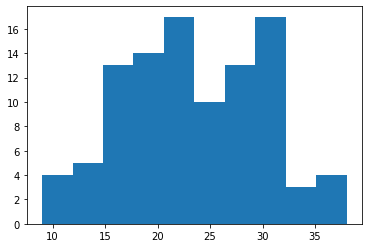

In [21]:
plt.hist(token_len_list)

In [22]:
def get_token_ids(text):
    encoding = tokenizer(text = text,
                         max_length = config.max_length,
                         padding="max_length",
                         truncation=True,
                         return_tensors = "pt",)
    return encoding

In [23]:
tokenizer.mask_token

'[MASK]'

In [24]:
mask_pos = [5, 6] # more one because cls token

In [25]:
prompt_template = '播报一则[MASK][MASK]新闻：'

In [26]:

tokenizer("播报一则[MASK][MASK]新闻：")['input_ids']


[101, 3064, 2845, 671, 1156, 103, 103, 3173, 7319, 8038, 102]

In [27]:
tokenizer.convert_ids_to_tokens(tokenizer("播报一则[MASK][MASK]新闻：")['input_ids'])

['[CLS]', '播', '报', '一', '则', '[MASK]', '[MASK]', '新', '闻', '：', '[SEP]']

#### Prompt Template

![Imgur](https://i.imgur.com/WySJb0s.png)

In [28]:
def inputs_process(data_text, data_label,mask_pos = mask_pos):

    #     mask_pos = [5, 6]

    encodings = []
    labels = []
    for text, label in zip(data_text, data_label):
        text = prompt_template + text # templata
        encoding = get_token_ids(text)
        encodings.append(encoding) 
        labels.append(label_index[label])

    item = {}
    for encoding in encodings:
        for key in ['input_ids', 'attention_mask']:
            if key in item.keys():
                item[key].append(encoding[key])
            else:
                item[key] = [encoding[key]]

    for key in ['input_ids', 'attention_mask']:
        item[key] = torch.cat(item[key])
        
    return item, labels

In [29]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [30]:
def get_data_loader(df):
    text  = df['text']
    label  = df['label']
    
    encoding, label = inputs_process(text, label)
    
    return DataLoader(Dataset(encoding, label), config.batch_size)

In [31]:
train_loader = get_data_loader(df_train)

In [32]:
dev_loader = get_data_loader(df_dev)

In [33]:
for sample in train_loader:
    break

In [34]:
sample['input_ids'].shape

torch.Size([8, 50])

In [35]:
sample.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

## 3) Prompt Tuning

### 3.1 Model Construction

In [36]:
# transformers.models.bert.modeling_bert.BertModel
from transformers import RobertaConfig, RobertaModel

In [37]:
from transformers.models.bert.modeling_bert import BertOnlyMLMHead

In [38]:
from torch import nn
import torch
from torch.nn import CrossEntropyLoss
from transformers import BertPreTrainedModel
from transformers.models.bert.modeling_bert import BertOnlyMLMHead


class BertForPromptTuning(BertPreTrainedModel):
    
    def __init__(self, config: RobertaConfig):
        
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = RobertaModel(config, add_pooling_layer=False)  # backbone
        self.cls = BertOnlyMLMHead(config)  # MLM vocab multi-classification
        self.init_weights()

    def set_output_embeddings(self, new_embeddings):
        """Use word embedding weight as the output weight in the cls layer"""
        self.cls.predictions.decoder.weight = new_embeddings.weight

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None):
        
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        self.set_output_embeddings(self.bert.embeddings.word_embeddings)

        # take the input ids embedding values
        inputs_embeds = self.bert.embeddings.word_embeddings(input_ids)

        outputs = self.bert(
            input_ids=None,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # outputs[0] -> shape [batch_size,max_length,hidden_size (768)]
        logits = self.cls(outputs[0])
        # logits:  -> shape [batch_size,max_length,vocab_size]

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            s = attention_mask.shape[0] * attention_mask.shape[1]
            loss = loss_fct(logits.view(s, -1), labels.view(-1))

        # logits: tokens out-> [batch_size,max_length,vocab_size]
        # pool out: outputs[1:] -> [batch_size,max_length,hidden_size]
        # cls : outputs[0][:, 0] -> first token cls output [batch_size,hidden_size]
        output = (logits,) + outputs[1:] + (outputs[0][:, 0],)
        return ((loss,) + output) if loss is not None else output

In [39]:
bert_name = config.bert_name

In [40]:
model = BertForPromptTuning.from_pretrained(bert_name)

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertForPromptTuning: ['bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForPromptTuning from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForPromptTuning from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForPromptTuning were not initialized from the model checkpoint at hfl/chinese-roberta-wwm-ext and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
model = model.to(config.device)

In [42]:
"""Test"""

'Test'

In [43]:
input_ids = sample['input_ids'].to(config.device)
attention_mask = sample['attention_mask'].to(config.device)

In [44]:
with torch.no_grad():
    out = model(input_ids=input_ids, attention_mask=attention_mask)

In [45]:
token_logits = out[0]

In [46]:
label_idx = label_idx_dic.values()
label_idx_0, label_idx_1 = zip(*label_idx)

In [47]:
# label_idx_0

In [48]:
mask_logits = token_logits[:, mask_pos[0]][:, label_idx_0] + \
              token_logits[:, mask_pos[1]][:, label_idx_1]

In [49]:
mask_logits.shape

torch.Size([8, 15])

In [50]:
mask_logits[0]

tensor([10.7480,  6.9740, 13.6546, 10.3883, 18.3691,  6.9044,  9.0074,  8.8410,
        12.2246,  9.5361,  6.5133, 14.2723,  7.1044,  9.2364,  6.4415],
       device='cuda:0')

In [51]:
torch.argmax(mask_logits, dim=1)

tensor([ 4,  2,  4,  6,  2, 11,  2, 11], device='cuda:0')

In [52]:
mask_logits = mask_logits[0:1]

In [53]:
mask_logits

tensor([[10.7480,  6.9740, 13.6546, 10.3883, 18.3691,  6.9044,  9.0074,  8.8410,
         12.2246,  9.5361,  6.5133, 14.2723,  7.1044,  9.2364,  6.4415]],
       device='cuda:0')

In [54]:
labels =sample['labels'].to(config.device)

In [55]:
labels = labels[0:1]

In [56]:
labels

tensor([4], device='cuda:0')

In [57]:
loss_fct = torch.nn.CrossEntropyLoss()
loss = loss_fct(mask_logits, labels)

In [58]:
labels = torch.tensor([0]).to(config.device)

In [59]:
labels

tensor([0], device='cuda:0')

In [60]:
loss = loss_fct(mask_logits, labels)

In [61]:
loss

tensor(7.6497, device='cuda:0')

### 3.2 Fine Tuning

In [62]:
optimizer = AdamW(model.parameters(), lr=config.learning_rate)

In [63]:
def train_step(data):
    
    input_ids = data['input_ids'].to(config.device)
    attention_mask = data['attention_mask'].to(config.device)
    out = model(input_ids=input_ids, attention_mask=attention_mask)

    label_idx = label_idx_dic.values()
    label_idx_0, label_idx_1 = zip(*label_idx)

    token_logits = out[0]
    # Take the vocab predictions, add together and take argmax
    mask_logits = token_logits[:, mask_pos[0]][:, label_idx_0] + \
                  token_logits[:, mask_pos[1]][:, label_idx_1]
    
    y_pred = torch.argmax(mask_logits, dim=1)
    y_true = data['labels'].to(config.device)

    loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(mask_logits, y_true)

    return loss, y_pred.cpu().numpy(), y_true.cpu().numpy()


In [64]:
def calculate_metrics(all_label,all_pred):
    
    acc = accuracy_score(all_label, all_pred)
    
    return acc 

In [65]:
def print_metrics(mode,loss,acc):
    result_str = f'{mode} loss:{loss:.4f} acc:{acc:.4f}'
    print(result_str)

In [66]:
def train_func(loader):
    train_loss = 0
    all_label = []
    all_pred = []
    pbar = tqdm(loader)
    for batch in pbar:
        optimizer.zero_grad()
        loss, output, label = train_step(batch)
        if output is not None and label is not None:
            all_label.extend(label)
            all_pred.extend(output)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()

        pbar.update()
        pbar.set_description(f'loss:{loss.item():.4f}')

    print_metrics('train', train_loss / len(loader),calculate_metrics(all_label, all_pred))

In [67]:
def dev_func(loader):

    dev_loss = 0

    all_label = []
    all_pred = []
    metrics = {}
    for batch in tqdm(loader):
        with torch.no_grad():
            loss, output, label = train_step(batch)
            dev_loss += loss.item()
            if output is not None:
                all_label.extend(label)
                all_pred.extend(output)

    if all_pred is not None:
        acc = calculate_metrics(all_label, all_pred)
        print_metrics("dev", dev_loss / len(loader), acc)
        target_names = [f'class {i}' for i in range(len(set(all_label)))]
#         print(classification_report(all_label, all_pred, target_names=target_names))


In [68]:
for epoch in range(config.epochs):
    
    print(f'***********epoch: {epoch + 1}***********')
    
    train_func(train_loader)
    
    dev_func(dev_loader)
    

***********epoch: 1***********


loss:1.5513: 100%|█████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.12it/s]


train loss:2.4800 acc:0.4500


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


dev loss:2.0098 acc:0.5100
***********epoch: 2***********


loss:0.0888: 100%|█████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.11it/s]


train loss:0.5118 acc:0.8200


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]

dev loss:1.9708 acc:0.5000
